In [1]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

In [2]:
import os
import zipfile

# Path ZIP dan lokasi ekstraksi
zip_path = "/home/antariksa/Desktop/Coding/gestur-abjad/dataset/dataset-bisindo-22k.zip"
extract_path = "/home/antariksa/Desktop/Coding/gestur-abjad/ekstrakted"

# Ekstraksi jika folder belum ada
if not os.path.exists(extract_path):
    os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset berhasil diekstrak ke:", extract_path)


Dataset berhasil diekstrak ke: /home/antariksa/Desktop/Coding/gestur-abjad/ekstrakted


In [3]:
# Label mapping termasuk huruf Z
label_mapping = {
    'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4,
    'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9,
    'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14,
    'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19,
    'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24,
    'Z': 25
}

inv_label_mapping = {v: k for k, v in label_mapping.items()}

RANDOM_SEED = 26
PATH_DATASET = "/home/antariksa/Desktop/Coding/gestur-abjad/ekstrakted/bisindo"


In [4]:
# Create the DataFrame `df` by collecting image paths and labels
data = []
for label in label_mapping.keys():
    label_path = os.path.join(PATH_DATASET, "images", "train", label) # Assuming "train" is the subfolder for training data
    if os.path.exists(label_path):
        for fname in os.listdir(label_path):
            full_path = os.path.join(label_path, fname)
            if os.path.isfile(full_path):
                data.append({
                    "label": label_mapping[label],  # Store numerical label
                    "full_path": full_path
                })
    else:
        print(f"Warning: {label_path} not found, skipping.")

df = pd.DataFrame(data)

print(f"Total data points found: {len(df)}")

df_train, df_val = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=RANDOM_SEED)

Total data points found: 9169


In [5]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Mean & std
DATA_MEAN = (0.5,)
DATA_STD = (0.5,)

# Transformasi training (dengan rotasi fixed)
train_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((128, 128)),
    transforms.RandomChoice([  # rotasi tanpa black spot
        transforms.Lambda(lambda img: img),
        transforms.Lambda(lambda img: img.rotate(90, expand=True)),
        transforms.Lambda(lambda img: img.rotate(180, expand=True)),
        transforms.Lambda(lambda img: img.rotate(270, expand=True))
    ]),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=DATA_MEAN, std=DATA_STD)
])

# Transformasi validasi (tanpa augmentasi)
val_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=DATA_MEAN, std=DATA_STD)
])

# Fungsi untuk menampilkan perbandingan
def show_augmentation(img_path, transform):
    original = Image.open(img_path).convert("RGB")
    augmented = transform(original)

    # Kembalikan dari tensor ke PIL untuk visualisasi
    augmented = transforms.ToPILImage()(augmented * 0.5 + 0.5)  # unnormalize

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(original)
    ax[0].set_title("Original")
    ax[0].axis("off")

    ax[1].imshow(augmented)
    ax[1].set_title("Augmented")
    ax[1].axis("off")

    plt.show()

In [6]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['full_path']
        label = self.data.iloc[idx]['label']
        image = Image.open(img_path).convert('L')
        return self.transform(image), torch.tensor(label).long()
    

In [7]:
train_loader = DataLoader(CustomDataset(df_train, train_transform), batch_size=64, shuffle=True)
val_loader = DataLoader(CustomDataset(df_val, val_transform), batch_size=64, shuffle=False)

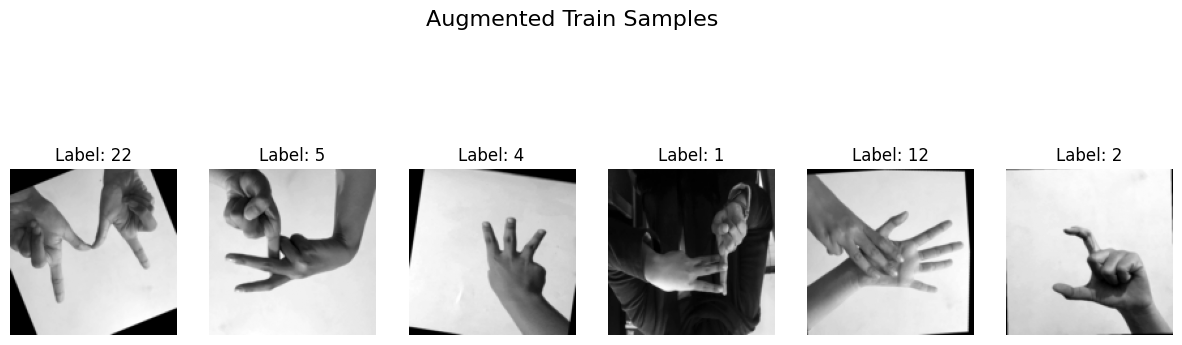

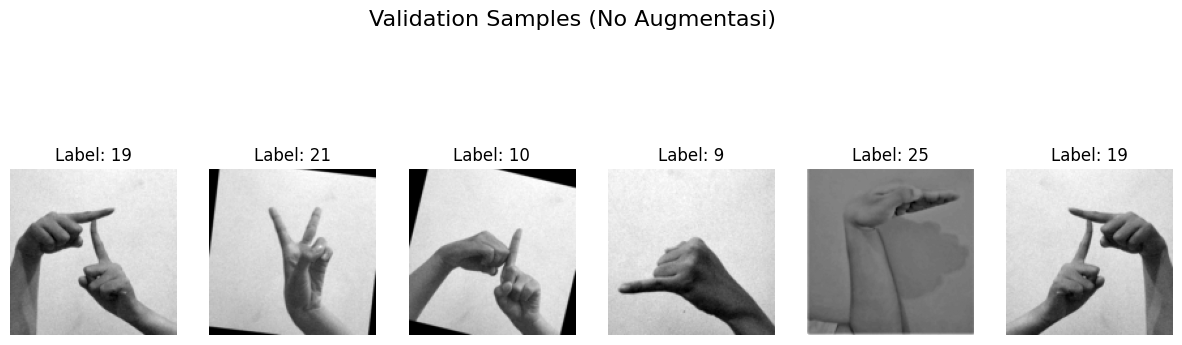

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def imshow_tensor(img_tensor):
    """Unnormalize dan tampilkan gambar dari tensor"""
    img_tensor = img_tensor * 0.5 + 0.5  # unnormalize (karena normalisasi mean=0.5, std=0.5)
    img_numpy = img_tensor.numpy().transpose((1, 2, 0))  # ubah channel untuk Matplotlib
    plt.imshow(img_numpy, cmap='gray')
    plt.axis('off')

def show_batch_samples(dataloader, title, n_images=6):
    dataiter = iter(dataloader)
    images, labels = next(dataiter)  # ambil batch pertama
    plt.figure(figsize=(15, 5))
    plt.suptitle(title, fontsize=16)
    for i in range(n_images):
        plt.subplot(1, n_images, i+1)
        imshow_tensor(images[i])
        plt.title(f"Label: {labels[i].item()}")
    plt.show()

# Tampilkan beberapa sampel augmentasi dari train_dataset
show_batch_samples(train_loader, "Augmented Train Samples")

# Tampilkan beberapa sampel augmentasi dari val_dataset
show_batch_samples(val_loader, "Validation Samples (No Augmentasi)")


In [9]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, num_classes=26):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2), nn.Dropout2d(0.25),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2), nn.Dropout2d(0.25),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2), nn.Dropout2d(0.25)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            # PERBAIKAN DI SINI: Menggunakan ukuran input yang benar
            nn.Linear(128 * 16 * 16, 256), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        # Bentuk x di sini sebelum flatten adalah (batch_size, 128, 16, 16)
        return self.classifier(x)

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

# Asumsi: df_val adalah DataFrame validasi Anda yang sudah didefinisikan
# import pandas as pd
# df_val = pd.read_csv(...) # Contoh

def train_model(model, train_loader, val_loader, epochs, device):
    # Lists untuk menyimpan history
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': []
    }

    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    print("Memulai Training...")
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_loss, train_correct, total_train = 0, 0, 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = outputs.max(1)
            train_correct += (preds == labels).sum().item()
            total_train += labels.size(0)

        # Validation Phase
        model.eval()
        val_loss, val_correct, total_val = 0, 0, 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]", leave=False):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                _, preds = outputs.max(1)
                val_correct += (preds == labels).sum().item()
                total_val += labels.size(0)

        # Hitung rata-rata loss dan akurasi untuk epoch ini
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_acc = train_correct / total_train
        val_acc = val_correct / total_val # Menggunakan total_val untuk konsistensi

        # Simpan ke history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%")

    print("Training Selesai!")
    return history

def plot_history(history):
    # Plotting Training & Validation Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Training Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plotting Training & Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# --- CONTOH PENGGUNAAN ---
# Misalkan model, train_loader, val_loader, dll. sudah Anda siapkan
# epochs = 25
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#
# # Panggil fungsi training dan simpan history-nya
# training_history = train_model(model, train_loader, val_loader, epochs, device)
#
# # Panggil fungsi plotting
# plot_history(training_history)

In [11]:
!nvidia-smi

Sun Aug 31 19:38:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.64.03              Driver Version: 575.64.03      CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   43C    P0             14W /   35W |      15MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [12]:
model = CNN(num_classes=26)

EPOCH = 150 # ubah epoch berdasarkan berapa kali model ingin di training
DEVICE = 'cuda' # 'cuda' apabila bisa menggunakan gpu dan 'cpu' apabila ingin menggunakan cpu

training_history = train_model(model, train_loader, val_loader, device=DEVICE, epochs=EPOCH)
    
nama_file = f"cnn_handsign_model_{EPOCH}_epoch.pth"
torch.save(model.state_dict(), nama_file)

print(f"Model berhasil disimpan sebagai: {nama_file}") # Ubah string untuk menentukan apa nama model yang akan di simpan

Memulai Training...


Epoch 1/150 | Train Loss: 3.2659 | Val Loss: 3.1939 | Train Acc: 4.87% | Val Acc: 9.71%


Epoch 2/150 | Train Loss: 3.1612 | Val Loss: 3.0015 | Train Acc: 7.39% | Val Acc: 13.09%


Epoch 3/150 | Train Loss: 2.9938 | Val Loss: 2.6839 | Train Acc: 11.62% | Val Acc: 32.22%


Epoch 4/150 | Train Loss: 2.7595 | Val Loss: 2.2789 | Train Acc: 18.75% | Val Acc: 50.82%


Epoch 5/150 | Train Loss: 2.5121 | Val Loss: 1.9672 | Train Acc: 25.52% | Val Acc: 57.14%


Epoch 6/150 | Train Loss: 2.3159 | Val Loss: 1.7306 | Train Acc: 31.59% | Val Acc: 61.34%


Epoch 7/150 | Train Loss: 2.1577 | Val Loss: 1.5858 | Train Acc: 36.14% | Val Acc: 63.85%


Epoch 8/150 | Train Loss: 2.0518 | Val Loss: 1.4779 | Train Acc: 39.63% | Val Acc: 65.38%


Epoch 9/150 | Train Loss: 1.9470 | Val Loss: 1.3902 | Train Acc: 42.64% | Val Acc: 66.63%


Epoch 10/150 | Train Loss: 1.8913 | Val Loss: 1.3355 | Train Acc: 44.09% | Val Acc: 67.50%


Epoch 11/150 | Train Loss: 1.8110 | Val Loss: 1.2584 | Train Acc: 46.27% | Val Acc: 69.03%


Epoch 12/150 | Train Loss: 1.7563 | Val Loss: 1.2280 | Train Acc: 48.48% | Val Acc: 68.81%


Epoch 13/150 | Train Loss: 1.7384 | Val Loss: 1.1782 | Train Acc: 49.01% | Val Acc: 69.90%


Epoch 14/150 | Train Loss: 1.6766 | Val Loss: 1.1613 | Train Acc: 50.07% | Val Acc: 69.52%


Epoch 15/150 | Train Loss: 1.6331 | Val Loss: 1.1406 | Train Acc: 51.44% | Val Acc: 70.07%


Epoch 16/150 | Train Loss: 1.6109 | Val Loss: 1.1017 | Train Acc: 52.67% | Val Acc: 71.16%


Epoch 17/150 | Train Loss: 1.5771 | Val Loss: 1.0894 | Train Acc: 53.88% | Val Acc: 70.88%


Epoch 18/150 | Train Loss: 1.5536 | Val Loss: 1.0784 | Train Acc: 54.41% | Val Acc: 70.99%


Epoch 19/150 | Train Loss: 1.5163 | Val Loss: 1.0632 | Train Acc: 55.45% | Val Acc: 71.10%


Epoch 20/150 | Train Loss: 1.5151 | Val Loss: 1.0502 | Train Acc: 55.49% | Val Acc: 71.32%


Epoch 21/150 | Train Loss: 1.4757 | Val Loss: 1.0477 | Train Acc: 56.92% | Val Acc: 71.81%


Epoch 22/150 | Train Loss: 1.4427 | Val Loss: 1.0386 | Train Acc: 58.35% | Val Acc: 71.86%


Epoch 23/150 | Train Loss: 1.4685 | Val Loss: 1.0415 | Train Acc: 57.66% | Val Acc: 71.43%


Epoch 24/150 | Train Loss: 1.4458 | Val Loss: 1.0251 | Train Acc: 57.08% | Val Acc: 72.14%


Epoch 25/150 | Train Loss: 1.4205 | Val Loss: 1.0183 | Train Acc: 58.36% | Val Acc: 71.97%


Epoch 26/150 | Train Loss: 1.4229 | Val Loss: 1.0152 | Train Acc: 57.93% | Val Acc: 72.25%


Epoch 27/150 | Train Loss: 1.3816 | Val Loss: 1.0091 | Train Acc: 58.64% | Val Acc: 72.25%


Epoch 28/150 | Train Loss: 1.3809 | Val Loss: 0.9963 | Train Acc: 59.25% | Val Acc: 72.52%


Epoch 29/150 | Train Loss: 1.3794 | Val Loss: 0.9912 | Train Acc: 59.22% | Val Acc: 72.68%


Epoch 30/150 | Train Loss: 1.3625 | Val Loss: 0.9991 | Train Acc: 58.77% | Val Acc: 72.36%


Epoch 31/150 | Train Loss: 1.3595 | Val Loss: 0.9872 | Train Acc: 60.20% | Val Acc: 72.57%


Epoch 32/150 | Train Loss: 1.3614 | Val Loss: 0.9842 | Train Acc: 59.65% | Val Acc: 72.68%


Epoch 33/150 | Train Loss: 1.3410 | Val Loss: 0.9812 | Train Acc: 60.60% | Val Acc: 72.85%


Epoch 34/150 | Train Loss: 1.3305 | Val Loss: 0.9834 | Train Acc: 60.33% | Val Acc: 72.79%


Epoch 35/150 | Train Loss: 1.3113 | Val Loss: 0.9735 | Train Acc: 60.94% | Val Acc: 73.17%


Epoch 36/150 | Train Loss: 1.3078 | Val Loss: 0.9763 | Train Acc: 60.90% | Val Acc: 73.06%


Epoch 37/150 | Train Loss: 1.3083 | Val Loss: 0.9792 | Train Acc: 60.85% | Val Acc: 72.85%


Epoch 38/150 | Train Loss: 1.2964 | Val Loss: 0.9682 | Train Acc: 61.38% | Val Acc: 72.96%


Epoch 39/150 | Train Loss: 1.3004 | Val Loss: 0.9734 | Train Acc: 60.87% | Val Acc: 72.96%


Epoch 40/150 | Train Loss: 1.2984 | Val Loss: 0.9731 | Train Acc: 61.68% | Val Acc: 73.12%


Epoch 41/150 | Train Loss: 1.2940 | Val Loss: 0.9632 | Train Acc: 61.32% | Val Acc: 72.79%


Epoch 42/150 | Train Loss: 1.2943 | Val Loss: 0.9675 | Train Acc: 61.24% | Val Acc: 73.28%


Epoch 43/150 | Train Loss: 1.2812 | Val Loss: 0.9611 | Train Acc: 61.72% | Val Acc: 73.01%


Epoch 44/150 | Train Loss: 1.2625 | Val Loss: 0.9555 | Train Acc: 62.25% | Val Acc: 73.28%


Epoch 45/150 | Train Loss: 1.2467 | Val Loss: 0.9554 | Train Acc: 62.62% | Val Acc: 73.12%


Epoch 46/150 | Train Loss: 1.2740 | Val Loss: 0.9576 | Train Acc: 62.25% | Val Acc: 73.23%


Epoch 47/150 | Train Loss: 1.2538 | Val Loss: 0.9490 | Train Acc: 62.51% | Val Acc: 73.56%


Epoch 48/150 | Train Loss: 1.2659 | Val Loss: 0.9573 | Train Acc: 61.95% | Val Acc: 73.34%


Epoch 49/150 | Train Loss: 1.2596 | Val Loss: 0.9482 | Train Acc: 62.71% | Val Acc: 73.45%


Epoch 50/150 | Train Loss: 1.2541 | Val Loss: 0.9464 | Train Acc: 62.67% | Val Acc: 73.45%


Epoch 51/150 | Train Loss: 1.2478 | Val Loss: 0.9460 | Train Acc: 62.28% | Val Acc: 73.72%


Epoch 52/150 | Train Loss: 1.2360 | Val Loss: 0.9564 | Train Acc: 62.81% | Val Acc: 73.56%


Epoch 53/150 | Train Loss: 1.2393 | Val Loss: 0.9518 | Train Acc: 62.94% | Val Acc: 73.45%


Epoch 54/150 | Train Loss: 1.2281 | Val Loss: 0.9591 | Train Acc: 63.16% | Val Acc: 73.17%


Epoch 55/150 | Train Loss: 1.2269 | Val Loss: 0.9563 | Train Acc: 62.81% | Val Acc: 73.12%


Epoch 56/150 | Train Loss: 1.2151 | Val Loss: 0.9452 | Train Acc: 63.74% | Val Acc: 73.17%


Epoch 57/150 | Train Loss: 1.2085 | Val Loss: 0.9452 | Train Acc: 63.61% | Val Acc: 73.56%


Epoch 58/150 | Train Loss: 1.2055 | Val Loss: 0.9336 | Train Acc: 63.59% | Val Acc: 73.50%


Epoch 59/150 | Train Loss: 1.2089 | Val Loss: 0.9447 | Train Acc: 63.75% | Val Acc: 73.72%


Epoch 60/150 | Train Loss: 1.2066 | Val Loss: 0.9384 | Train Acc: 63.75% | Val Acc: 73.88%


Epoch 61/150 | Train Loss: 1.2043 | Val Loss: 0.9348 | Train Acc: 63.26% | Val Acc: 74.26%


Epoch 62/150 | Train Loss: 1.2115 | Val Loss: 0.9375 | Train Acc: 62.90% | Val Acc: 74.21%


Epoch 63/150 | Train Loss: 1.1962 | Val Loss: 0.9434 | Train Acc: 63.54% | Val Acc: 73.77%


Epoch 64/150 | Train Loss: 1.1954 | Val Loss: 0.9391 | Train Acc: 63.80% | Val Acc: 73.56%


Epoch 65/150 | Train Loss: 1.1727 | Val Loss: 0.9274 | Train Acc: 64.34% | Val Acc: 73.50%


Epoch 66/150 | Train Loss: 1.1740 | Val Loss: 0.9357 | Train Acc: 63.87% | Val Acc: 73.56%


Epoch 67/150 | Train Loss: 1.1834 | Val Loss: 0.9356 | Train Acc: 64.05% | Val Acc: 73.72%


Epoch 68/150 | Train Loss: 1.1853 | Val Loss: 0.9368 | Train Acc: 63.95% | Val Acc: 73.72%


Epoch 69/150 | Train Loss: 1.1813 | Val Loss: 0.9351 | Train Acc: 63.97% | Val Acc: 73.83%


Epoch 70/150 | Train Loss: 1.1688 | Val Loss: 0.9283 | Train Acc: 64.25% | Val Acc: 73.61%


Epoch 71/150 | Train Loss: 1.1659 | Val Loss: 0.9295 | Train Acc: 64.02% | Val Acc: 73.88%


Epoch 72/150 | Train Loss: 1.1705 | Val Loss: 0.9229 | Train Acc: 64.01% | Val Acc: 73.94%


Epoch 73/150 | Train Loss: 1.1489 | Val Loss: 0.9260 | Train Acc: 65.28% | Val Acc: 73.61%


Epoch 74/150 | Train Loss: 1.1491 | Val Loss: 0.9238 | Train Acc: 65.09% | Val Acc: 73.50%


Epoch 75/150 | Train Loss: 1.1706 | Val Loss: 0.9326 | Train Acc: 64.13% | Val Acc: 74.10%


Epoch 76/150 | Train Loss: 1.1531 | Val Loss: 0.9267 | Train Acc: 64.72% | Val Acc: 73.66%


Epoch 77/150 | Train Loss: 1.1517 | Val Loss: 0.9432 | Train Acc: 64.77% | Val Acc: 73.17%


Epoch 78/150 | Train Loss: 1.1533 | Val Loss: 0.9262 | Train Acc: 65.03% | Val Acc: 73.61%


Epoch 79/150 | Train Loss: 1.1510 | Val Loss: 0.9324 | Train Acc: 64.95% | Val Acc: 73.72%


Epoch 80/150 | Train Loss: 1.1452 | Val Loss: 0.9261 | Train Acc: 64.65% | Val Acc: 73.94%


Epoch 81/150 | Train Loss: 1.1457 | Val Loss: 0.9201 | Train Acc: 64.81% | Val Acc: 74.21%


Epoch 82/150 | Train Loss: 1.1598 | Val Loss: 0.9175 | Train Acc: 64.68% | Val Acc: 74.37%


Epoch 83/150 | Train Loss: 1.1286 | Val Loss: 0.9212 | Train Acc: 65.36% | Val Acc: 73.72%


Epoch 84/150 | Train Loss: 1.1327 | Val Loss: 0.9417 | Train Acc: 65.56% | Val Acc: 73.88%


Epoch 85/150 | Train Loss: 1.1477 | Val Loss: 0.9194 | Train Acc: 64.38% | Val Acc: 74.05%


Epoch 86/150 | Train Loss: 1.1293 | Val Loss: 0.9242 | Train Acc: 65.33% | Val Acc: 73.83%


Epoch 87/150 | Train Loss: 1.1322 | Val Loss: 0.9168 | Train Acc: 65.78% | Val Acc: 73.77%


Epoch 88/150 | Train Loss: 1.1482 | Val Loss: 0.9156 | Train Acc: 64.74% | Val Acc: 73.88%


Epoch 89/150 | Train Loss: 1.1275 | Val Loss: 0.9345 | Train Acc: 65.36% | Val Acc: 74.10%


Epoch 90/150 | Train Loss: 1.1220 | Val Loss: 0.9185 | Train Acc: 65.55% | Val Acc: 73.88%


Epoch 91/150 | Train Loss: 1.1332 | Val Loss: 0.9188 | Train Acc: 64.98% | Val Acc: 74.21%


Epoch 92/150 | Train Loss: 1.1234 | Val Loss: 0.9197 | Train Acc: 64.99% | Val Acc: 73.88%


Epoch 93/150 | Train Loss: 1.1259 | Val Loss: 0.9141 | Train Acc: 65.21% | Val Acc: 74.10%


Epoch 94/150 | Train Loss: 1.1281 | Val Loss: 0.9119 | Train Acc: 65.15% | Val Acc: 74.15%


Epoch 95/150 | Train Loss: 1.1322 | Val Loss: 0.9172 | Train Acc: 65.04% | Val Acc: 73.94%


Epoch 96/150 | Train Loss: 1.1357 | Val Loss: 0.9183 | Train Acc: 65.06% | Val Acc: 74.15%


Epoch 97/150 | Train Loss: 1.1174 | Val Loss: 0.9101 | Train Acc: 65.40% | Val Acc: 74.48%


Epoch 98/150 | Train Loss: 1.1092 | Val Loss: 0.9234 | Train Acc: 65.51% | Val Acc: 74.37%


Epoch 99/150 | Train Loss: 1.1126 | Val Loss: 0.9268 | Train Acc: 65.26% | Val Acc: 74.05%


Epoch 100/150 | Train Loss: 1.1128 | Val Loss: 0.9154 | Train Acc: 65.77% | Val Acc: 74.48%


Epoch 101/150 | Train Loss: 1.1202 | Val Loss: 0.9092 | Train Acc: 65.49% | Val Acc: 74.32%


Epoch 102/150 | Train Loss: 1.1210 | Val Loss: 0.9165 | Train Acc: 65.79% | Val Acc: 74.21%


Epoch 103/150 | Train Loss: 1.0986 | Val Loss: 0.9080 | Train Acc: 66.12% | Val Acc: 74.75%


Epoch 104/150 | Train Loss: 1.1124 | Val Loss: 0.9261 | Train Acc: 65.51% | Val Acc: 74.54%


Epoch 105/150 | Train Loss: 1.1023 | Val Loss: 0.9227 | Train Acc: 65.70% | Val Acc: 74.05%


Epoch 106/150 | Train Loss: 1.1082 | Val Loss: 0.9086 | Train Acc: 65.45% | Val Acc: 74.32%


Epoch 107/150 | Train Loss: 1.1046 | Val Loss: 0.9183 | Train Acc: 66.00% | Val Acc: 73.94%


Epoch 108/150 | Train Loss: 1.1047 | Val Loss: 0.9160 | Train Acc: 65.66% | Val Acc: 74.48%


Epoch 109/150 | Train Loss: 1.1021 | Val Loss: 0.9187 | Train Acc: 66.04% | Val Acc: 74.32%


Epoch 110/150 | Train Loss: 1.0888 | Val Loss: 0.9049 | Train Acc: 66.54% | Val Acc: 74.59%


Epoch 111/150 | Train Loss: 1.0958 | Val Loss: 0.9115 | Train Acc: 66.04% | Val Acc: 74.10%


Epoch 112/150 | Train Loss: 1.0773 | Val Loss: 0.9122 | Train Acc: 66.56% | Val Acc: 73.99%


Epoch 113/150 | Train Loss: 1.0969 | Val Loss: 0.9066 | Train Acc: 66.16% | Val Acc: 74.26%


Epoch 114/150 | Train Loss: 1.0985 | Val Loss: 0.9208 | Train Acc: 65.58% | Val Acc: 74.26%


Epoch 115/150 | Train Loss: 1.0815 | Val Loss: 0.9157 | Train Acc: 66.00% | Val Acc: 74.21%


Epoch 116/150 | Train Loss: 1.0877 | Val Loss: 0.9059 | Train Acc: 66.15% | Val Acc: 74.10%


Epoch 117/150 | Train Loss: 1.0851 | Val Loss: 0.9045 | Train Acc: 65.94% | Val Acc: 74.15%


Epoch 118/150 | Train Loss: 1.0666 | Val Loss: 0.8986 | Train Acc: 67.02% | Val Acc: 74.48%


Epoch 119/150 | Train Loss: 1.0727 | Val Loss: 0.9141 | Train Acc: 66.48% | Val Acc: 74.37%


Epoch 120/150 | Train Loss: 1.0769 | Val Loss: 0.9055 | Train Acc: 66.05% | Val Acc: 74.70%


Epoch 121/150 | Train Loss: 1.0665 | Val Loss: 0.9047 | Train Acc: 66.63% | Val Acc: 74.32%


Epoch 122/150 | Train Loss: 1.0842 | Val Loss: 0.9008 | Train Acc: 66.20% | Val Acc: 74.97%


Epoch 123/150 | Train Loss: 1.0651 | Val Loss: 0.8977 | Train Acc: 67.14% | Val Acc: 74.59%


Epoch 124/150 | Train Loss: 1.0650 | Val Loss: 0.9002 | Train Acc: 66.76% | Val Acc: 74.75%


Epoch 125/150 | Train Loss: 1.0702 | Val Loss: 0.9012 | Train Acc: 66.68% | Val Acc: 75.08%


Epoch 126/150 | Train Loss: 1.0765 | Val Loss: 0.8928 | Train Acc: 66.50% | Val Acc: 74.86%


Epoch 127/150 | Train Loss: 1.0641 | Val Loss: 0.8953 | Train Acc: 67.08% | Val Acc: 74.70%


Epoch 128/150 | Train Loss: 1.0705 | Val Loss: 0.8984 | Train Acc: 66.46% | Val Acc: 74.37%


Epoch 129/150 | Train Loss: 1.0615 | Val Loss: 0.8991 | Train Acc: 67.36% | Val Acc: 74.70%


Epoch 130/150 | Train Loss: 1.0726 | Val Loss: 0.8978 | Train Acc: 66.64% | Val Acc: 74.26%


Epoch 131/150 | Train Loss: 1.0521 | Val Loss: 0.9233 | Train Acc: 67.27% | Val Acc: 74.10%


Epoch 132/150 | Train Loss: 1.0512 | Val Loss: 0.9083 | Train Acc: 66.58% | Val Acc: 74.54%


Epoch 133/150 | Train Loss: 1.0573 | Val Loss: 0.9047 | Train Acc: 67.08% | Val Acc: 74.32%


Epoch 134/150 | Train Loss: 1.0506 | Val Loss: 0.8987 | Train Acc: 66.94% | Val Acc: 74.92%


Epoch 135/150 | Train Loss: 1.0586 | Val Loss: 0.8979 | Train Acc: 66.88% | Val Acc: 74.81%


Epoch 136/150 | Train Loss: 1.0602 | Val Loss: 0.9004 | Train Acc: 66.61% | Val Acc: 74.48%


Epoch 137/150 | Train Loss: 1.0490 | Val Loss: 0.8993 | Train Acc: 67.46% | Val Acc: 74.92%


Epoch 138/150 | Train Loss: 1.0432 | Val Loss: 0.8987 | Train Acc: 67.23% | Val Acc: 75.03%


Epoch 139/150 | Train Loss: 1.0459 | Val Loss: 0.9107 | Train Acc: 67.51% | Val Acc: 74.32%


Epoch 140/150 | Train Loss: 1.0505 | Val Loss: 0.8988 | Train Acc: 67.01% | Val Acc: 74.43%


Epoch 141/150 | Train Loss: 1.0536 | Val Loss: 0.9078 | Train Acc: 67.28% | Val Acc: 74.37%


Epoch 142/150 | Train Loss: 1.0571 | Val Loss: 0.8921 | Train Acc: 66.69% | Val Acc: 74.81%


Epoch 143/150 | Train Loss: 1.0438 | Val Loss: 0.8862 | Train Acc: 67.36% | Val Acc: 75.08%


Epoch 144/150 | Train Loss: 1.0544 | Val Loss: 0.8947 | Train Acc: 66.90% | Val Acc: 74.75%


Epoch 145/150 | Train Loss: 1.0437 | Val Loss: 0.9009 | Train Acc: 67.32% | Val Acc: 74.65%


Epoch 146/150 | Train Loss: 1.0492 | Val Loss: 0.9117 | Train Acc: 67.25% | Val Acc: 74.54%


Epoch 147/150 | Train Loss: 1.0515 | Val Loss: 0.8907 | Train Acc: 67.20% | Val Acc: 74.59%


Epoch 148/150 | Train Loss: 1.0307 | Val Loss: 0.8906 | Train Acc: 67.47% | Val Acc: 74.70%


Epoch 149/150 | Train Loss: 1.0415 | Val Loss: 0.8929 | Train Acc: 67.29% | Val Acc: 74.70%


Epoch 150/150 | Train Loss: 1.0284 | Val Loss: 0.8911 | Train Acc: 67.76% | Val Acc: 74.48%
Training Selesai!
Model berhasil disimpan sebagai: cnn_handsign_model_150_epoch.pth


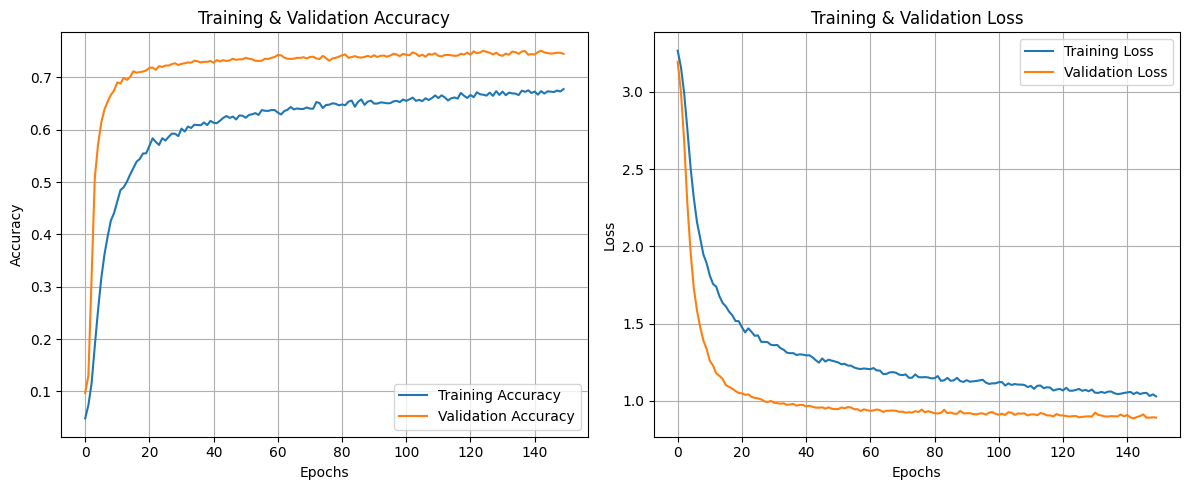

In [13]:
plot_history(training_history)

In [14]:
def evaluate(model, loader, device='cuda'):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    incorrect_samples = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device) # Move data to the correct device
            outputs = model(images)
            _, preds = outputs.max(1)
            total += labels.size(0)

            correct += (preds == labels).sum().item()
            for i in range(len(labels)):
                if preds[i] != labels[i]:
                    incorrect_samples.append((images[i].cpu(), preds[i].cpu(), labels[i].cpu()))

    print(f"Accuracy: {100 * correct / total:.2f}%")
    return incorrect_samples

In [15]:
import os
import pandas as pd
from torch.utils.data import DataLoader

# Try lowercase 'test' first
PATH_TEST = os.path.join(PATH_DATASET, "images/val")

# If lowercase 'test' doesn't exist, try uppercase 'Test' (though less likely based on previous errors)
if not os.path.exists(PATH_TEST):
    PATH_TEST = os.path.join(PATH_DATASET, "images/val")

print(f"Attempting to load test data from: {PATH_TEST}")

# Define LABELS from the keys of label_mapping
LABELS = list(label_mapping.keys())

data_test = []
if os.path.exists(PATH_TEST):
    for label in LABELS:
        label_path = os.path.join(PATH_TEST, label)
        if not os.path.exists(label_path):
            print(f"Warning: {label_path} tidak ditemukan, dilewati.")
            continue
        for fname in os.listdir(label_path):
            full_path = os.path.join(label_path, fname)
            if os.path.isfile(full_path):
                data_test.append({
                    "label": label,  # Simpan string label
                    "full_path": full_path
                })
else:
    print(f"Error: Test data directory not found at {PATH_TEST}")


df_test = pd.DataFrame(data_test)

# Only create DataLoader if test data was found
if len(df_test) > 0:
    test_loader = DataLoader(
        CustomDataset(df_test, val_transform), # Use BISINDODataset and correct paths
        batch_size=64,
        shuffle=False
    )
    print(f"Total data test: {len(df_test)}")
else:
    print("No test data found. Cannot create test_loader.")

Attempting to load test data from: /home/antariksa/Desktop/Coding/gestur-abjad/ekstrakted/bisindo/images/val
Total data test: 2301


✅ Bobot dari checkpoint 'cnn_handsign_model_150_epoch.pth' berhasil dimuat untuk evaluasi.


Evaluating: 100%|██████████| 36/36 [00:12<00:00,  2.91it/s]

Total prediksi salah: 590

Menampilkan 5 contoh prediksi yang salah:


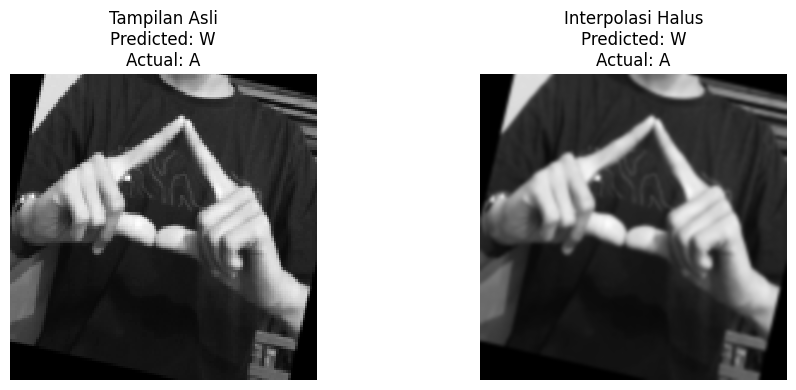

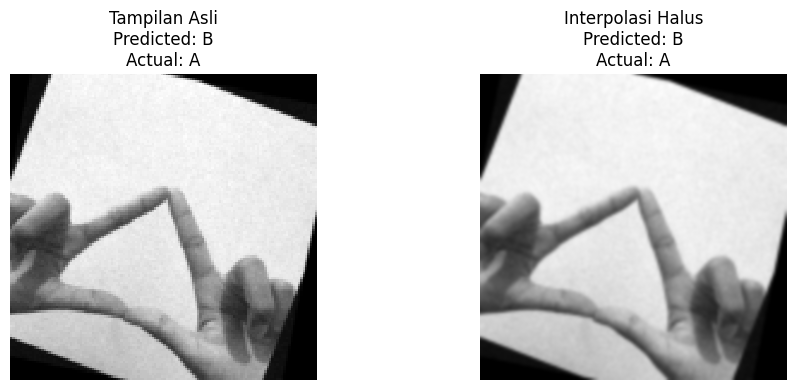

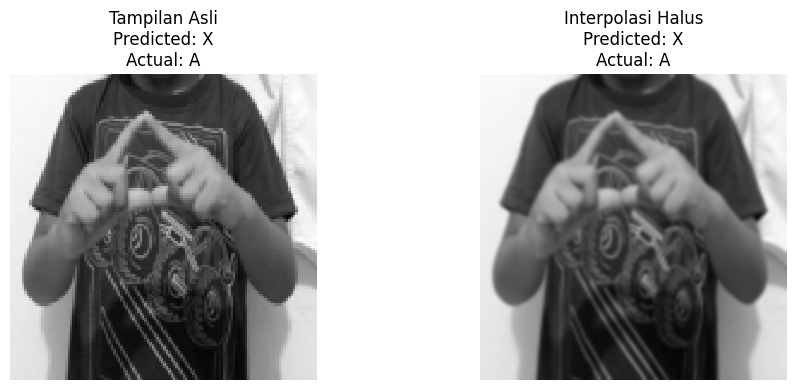

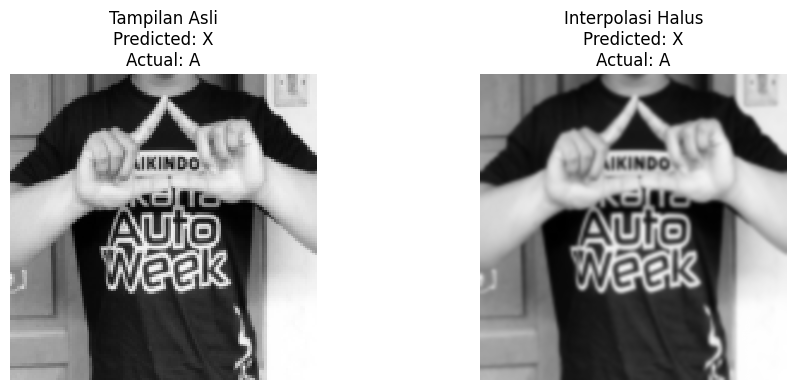

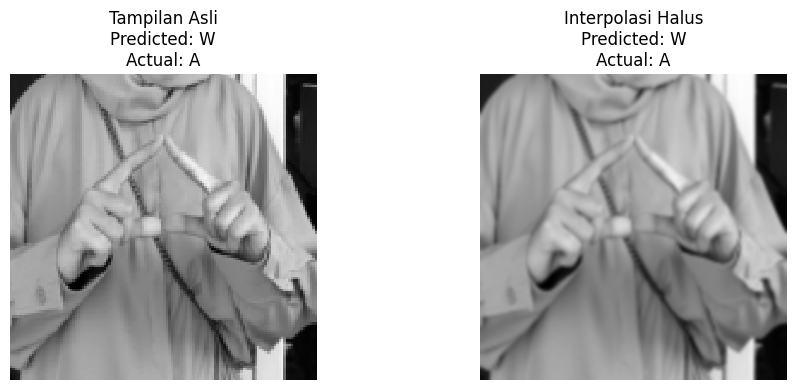

In [16]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from torch.utils.data import Dataset, DataLoader

# ---------------------------
# Mapping A-Z untuk plotting
# ---------------------------
letters = [chr(65 + i) for i in range(26)]  # ['A','B',...,'Z']
idx_to_label = {i: l for i, l in enumerate(letters)}

# ---------------------------
# Wrapper dataset untuk evaluasi
# ---------------------------
class EvalDataset(Dataset):
    """
    Wrapper yang membaca sumber data dari dataset asli (dataframe / samples)
    dan mengembalikan (image_tensor, label_int).
    Tujuan: menghindari __getitem__ asli yang mungkin memanggil torch.tensor pada string.
    """
    def __init__(self, base_dataset):
        self.base = base_dataset
        # Coba ambil DataFrame-like (paling umum di implementasi pengguna sebelumnya)
        if hasattr(base_dataset, "data"):
            self.mode = "df"
            self.df = base_dataset.data
        elif hasattr(base_dataset, "dataframe"):
            self.mode = "df"
            self.df = base_dataset.dataframe
        # fallback: list of (path, label) pairs
        elif hasattr(base_dataset, "samples"):
            self.mode = "samples"
            self.samples = base_dataset.samples
        elif hasattr(base_dataset, "imgs"):
            self.mode = "samples"
            self.samples = base_dataset.imgs
        else:
            raise RuntimeError("EvalDataset: tidak menemukan atribut 'data'/'samples'/'imgs' pada dataset asal.")
        # transform dari dataset asli (jika ada)
        self.transform = getattr(base_dataset, "transform", None)

    def __len__(self):
        return len(self.df) if self.mode == "df" else len(self.samples)

    def _path_from_row(self, row):
        # cari kolom path yang umum dipakai
        for key in ("path", "img_path", "image_path", "filename", "file", "img", "image"):
            if key in row.index:
                return row[key]
        # jika tidak ditemukan, coba kolom pertama yang terlihat seperti string path
        for k in row.index:
            v = row[k]
            if isinstance(v, str) and (v.endswith(".jpg") or v.endswith(".png") or "/" in v or "\\" in v):
                return v
        raise RuntimeError("EvalDataset: tidak dapat menemukan kolom path di DataFrame.")

    def _label_from_row(self, row):
        # cari kolom label yang umum
        for key in ("label", "labels", "target", "class"):
            if key in row.index:
                return row[key]
        # fallback: coba kolom kedua (jika format [path, label])
        # (berisiko, tetapi hanya fallback)
        try:
            # ambil elemen non-path pertama
            for k in row.index:
                if k not in ("path", "img_path", "image_path", "filename", "file", "img", "image"):
                    return row[k]
        except Exception:
            pass
        raise RuntimeError("EvalDataset: tidak dapat menemukan kolom label di DataFrame.")

    def _label_to_index(self, label_raw):
        # jika sudah integer
        if isinstance(label_raw, (int, np.integer)):
            return int(label_raw)
        # jika string yang berisi digit
        if isinstance(label_raw, str):
            s = label_raw.strip()
            if s.isdigit():
                return int(s)
            # jika huruf (A..Z)
            ch = s[0].upper()
            if "A" <= ch <= "Z":
                return ord(ch) - 65
            # jika base dataset memiliki mapping class_to_idx
            if hasattr(self.base, "class_to_idx") and isinstance(self.base.class_to_idx, dict):
                if s in self.base.class_to_idx:
                    return int(self.base.class_to_idx[s])
        # terakhir coba cast ke int
        try:
            return int(label_raw)
        except Exception:
            raise ValueError(f"EvalDataset: tidak dapat konversi label: {label_raw!r}")

    def __getitem__(self, idx):
        if self.mode == "df":
            row = self.df.iloc[idx]
            img_path = self._path_from_row(row)
            label_raw = self._label_from_row(row)
        else:
            entry = self.samples[idx]
            # entry biasanya (path, label) atau (path, label, something)
            if isinstance(entry, (list, tuple)) and len(entry) >= 2:
                img_path, label_raw = entry[0], entry[1]
            else:
                raise RuntimeError("EvalDataset: format samples tidak dikenali.")
        # Baca image (gunakan PIL agar kompatibel dengan transform)
        img = Image.open(img_path).convert("L")  # grayscale sesuai kode sebelumnya
        if self.transform:
            img = self.transform(img)
        # konversi label ke integer
        label_idx = self._label_to_index(label_raw)
        return img, torch.tensor(label_idx).long()

# ---------------------------
# Fungsi evaluasi (menggunakan DataLoader baru)
# ---------------------------
def evaluate(model, loader, device):
    model.eval()
    incorrect_samples = []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating"):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            for img, pred, lbl in zip(images, preds, labels):
                if pred != lbl:
                    incorrect_samples.append((img.cpu(), pred.cpu(), lbl.cpu()))
    return incorrect_samples

# ===========================
# Re-initialize model & muat bobot
# ===========================
model = CNN(num_classes=26)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

checkpoint_path = "cnn_handsign_model_150_epoch.pth"
if os.path.exists(checkpoint_path):
    try:
        model.load_state_dict(torch.load(checkpoint_path, map_location=device))
        print(f"✅ Bobot dari checkpoint '{checkpoint_path}' berhasil dimuat untuk evaluasi.")
    except Exception as e:
        print(f"❌ Gagal memuat checkpoint untuk evaluasi: {e}")
else:
    print(f"🔎 Checkpoint '{checkpoint_path}' tidak ditemukan. Evaluasi akan menggunakan model yang tidak terlatih.")

# ===========================
# Buat EvalDataset & eval_loader (mengganti test_loader sementara)
# ===========================
try:
    eval_dataset = EvalDataset(test_loader.dataset)
    batch_size = getattr(test_loader, "batch_size", 32) or 32
    eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
except Exception as e:
    raise RuntimeError("Gagal membuat eval dataset wrapper. Periksa atribut test_loader.dataset. Error: " + str(e))

# Jalankan evaluasi menggunakan eval_loader
incorrect = evaluate(model, eval_loader, device=device)
print(f"Total prediksi salah: {len(incorrect)}")

# ===========================
# Tampilkan 5 contoh prediksi salah
# ===========================
print("\nMenampilkan 5 contoh prediksi yang salah:")
for i in range(min(5, len(incorrect))):
    img, pred, label = incorrect[i]

    # Konversi tensor image ke array numpy untuk plotting
    img_arr = img.numpy()
    # Jika bernormalisasi ke rentang [-1,1], denormalize asumsi mean=0.5 std=0.5
    if img_arr.min() < -0.1:
        img_arr = img_arr * 0.5 + 0.5

    # Jika channel-first (C,H,W)
    if img_arr.ndim == 3:
        if img_arr.shape[0] == 1:
            img_display = img_arr.squeeze(0)
            is_gray = True
        else:
            img_display = np.transpose(img_arr, (1, 2, 0))
            is_gray = False
    else:
        img_display = img_arr
        is_gray = True

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    if is_gray:
        plt.imshow(img_display, cmap='gray', interpolation='none')
    else:
        plt.imshow(img_display, interpolation='none')
    plt.title(f"Tampilan Asli\nPredicted: {idx_to_label.get(pred.item(), str(pred.item()))}\nActual: {idx_to_label.get(label.item(), str(label.item()))}")
    plt.axis('off')

    plt.subplot(1,2,2)
    if is_gray:
        plt.imshow(img_display, cmap='gray', interpolation='bicubic')
    else:
        plt.imshow(img_display, interpolation='bicubic')
    plt.title(f"Interpolasi Halus\nPredicted: {idx_to_label.get(pred.item(), str(pred.item()))}\nActual: {idx_to_label.get(label.item(), str(label.item()))}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


In [17]:
# Create the DataFrame `df` by collecting image paths and labels
data = []
for label in label_mapping.keys():
    label_path = os.path.join(PATH_DATASET, "images", "train", label) # Assuming "train" is the subfolder for training data
    if os.path.exists(label_path):
        for fname in os.listdir(label_path):
            full_path = os.path.join(label_path, fname)
            if os.path.isfile(full_path):
                data.append({
                    "label": label_mapping[label],  # Store numerical label
                    "full_path": full_path
                })
    else:
        print(f"Warning: {label_path} not found, skipping.")

df = pd.DataFrame(data)

print(f"Total data points found: {len(df)}")

Total data points found: 9169
